<a id='begin'></a>
# Оглавление

- ### [Импорт библиотек](#upload) 
    
- ### [Коллаборативная фильтрация](#collaborative)
    - [Предобработка данных](#collaborative_preprocessing)
    - [Модель](#collaborative_model)
    
- ### [ALS - модель](#als)
    - [Предобработка данных](#als_surprise_preprocessing)
    - [Модель](#als_surprise_model)
    
- ### [Матричная факторизация и факторизационные машины](#factorization)

- ### [Implicit ALS (Alternating Least Squares) - модель](#als_implicit)
    - [Предобработка данных](#als_implicit_preprocessing)
    - [Модель](#als_implicit_model)
    
- ### [GradientBoost Classifier](#gradient)
    - [Предобработка данных](#gradient_preprocessing)
    - [Модель](#gradient_model)
    
- ### [XGBoost](#xgboost)
    - [Предобработка данных](#xgboost_preprocessing)
    - [Модель](#xgboost_model)

<a id='upload'></a>
## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import pickle

Создадим пустой словарь для фиксации результата технических метрик.

In [2]:
rmse_score_dict = {}
map_at_k_score_dict = {}

Импорт двух датасетов:
- df_events - очищенный датасет events с добавленными features (все).
- df_temp - очищенный датасет events с добавленными features (только нужные) и данным о конечном результата взаимодействия между пользователем и товаром.
- df_all_features - очищенный датасет events с добавленными features (все) и данным о конечном результата взаимодействия между пользователем и товаром.
</br>
</br>
Далее у каждой модели закомментирован нужный модели датасет, для уменьшения нагрузки.

In [3]:
# df_events = pd.read_csv('df_events.csv', sep = ';').drop(columns = ['Unnamed: 0'])
# df_temp = pd.read_csv('df_temp.csv', sep = ';').drop(columns = ['Unnamed: 0'])
# df_all_features = pd.read_csv('df_temp_features.csv', sep = ';').drop(columns = ['Unnamed: 0'])

<a id='collaborative'></a>
# Коллаборативная фильтрация

Коллаборативная фильтрация (CF - collaborative filtering) - метод построения прогноза на основе предыдущих действий пользователя (user) по отношению к продукту (item). Измененная форма модели позволяет делать прогноз, используя схожесть товаров по отношению к товару, которому пользователь поставил оценку.

### Коллаборативная фильтрация: item-based

<i><b>Item-based filtering</b></i> (a.k.a Item-Item или Item-to-Item) - позволяет поставить оценку товару, используя среднюю взвешенную оценку похожих товаров, с которыми взаимодействовали пользователи:
</br>
</br>
$$\hat{r}_{ui} = \mu_i + \dfrac {\sum_{j \in N_k^u(i)} \text{sim}(i, j) \cdot (\hat{r}_{ui} - \mu_i)} {\sum_{j \in N_k^u(i)} sim(i, j)}$$
</br>
</br>
Почему Item-based filtering подходит в нашем случае? 
- Item-based filtering используется чаще, чем user-based filtering, из-за динамической природы данных о самих пользователей. </br>Item менее подвержен изменениям и потребность в повторных тренировок модели отпадает.
- Мы имеем большой датасет с наличием большого перевеса невостребованных товаров (смотрят, но не покупают). </br>При тренировки модели на user-based фильтрации мы получим матрицу большой размерности, которая в свою очередь не сможет быть обработана моделью (Memory-bound).
- Для явных данных, как в нашем случае, модели коллаборативной фильтрации, с алгоритмами семейства ближайших соседей, хорошо подходят.
</br>
</br>
Для определения схожести чаще используют два способа: <i><b>коэффициент корреляции Пирсона</b></i> или <i><b>косинусное расстояние</b></i>. 
</br>Мы будем использовать косинусное расстояние:
</br>
</br>
$$\cos(0) = \dfrac {A \times B}{||A||||B||} = \dfrac {\sum_{i=1}^{n} A_{i} \times B_{i}}{\sqrt{\sum_{i=1}^{n} (A_{i})^2} \sqrt{\sum_{i=1}^{n} (B_{i})^2}}$$
</br>
</br>
Для оценки качества будем использовать установленную в библиотеку surprise метрику RMSE (Root Mean Squared Error):
</br>
</br>
$$\text{RMSE} = \sqrt{\dfrac {1}{|\hat{R}|}\sum_{\hat{r}_{ui} \in \hat{R}}(\hat{r}_{ui} - \mu_i)^2}$$

## Датасет

In [93]:
df_events = pd.read_csv('df_events.csv', sep = ';').drop(columns = ['Unnamed: 0'])

df_events = df_events[df_events['visitorid'] < 20000]

<a id='collaborative_preprocessing'></a>
## Предобработка данных

Загрузим нужные нам модули из библиотеки surprise.

In [94]:
from surprise import KNNWithMeans, KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

Преобразуем категориальные переменные в численные.

In [95]:
# Creating new column - rating
df_events['rating'] = df_events['event'].apply(lambda x: 1.0 if str(x) == 'view' else (2.0 if str(x) == 'addtocart' else 3.0))

Удалим лишние столбцы, оставив только visitorid, itemid и rating.

In [96]:
# Drop unnecessary columns
user_item = df_events.copy()
user_item.drop(columns = ['event', 'addtocart', 'date', 'datetime', 'day', 'day_of_week',
                          'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                          'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'day_period', 
                          'hour', 'minute', 'month', 'timestamp', 'transaction',
                          'transactionid', 'view', 'year'], inplace = True)

Библиотека surprise имеет свои внутрение правила распознания признаков. Необходимо переименовать нужные нам признаки.

In [97]:
# Rename columns (surprise rules)
dataset = user_item.rename(columns = {
    "visitorid": "uid",
    "itemid": "iid",
    "event_count": "rating"})

Меняем тип данных признаков.

In [98]:
# Change column types
dataset['rating'] = dataset['rating'].astype(float)
dataset['uid'] = dataset['uid'].astype(float)
dataset['iid'] = dataset['iid'].astype(object)

fig, ax = plt.subplots(figsize = (5, 2))
plt.hist(dataset['rating'])

Сократим кол-во items: оставим items, которые хотя бы раз получали рейтинг = 3 (были приобретены) или = 2 (были добавлены в корзину).

In [99]:
# items_id = []
# for i in dataset[(dataset['rating'] == 3.0) | (dataset['rating'] == 2.0)].index:
#     items_id.append(dataset['iid'][i])
    
# dataset = dataset[(dataset['iid'].isin(items_id))]

# fig, ax = plt.subplots(figsize = (5, 2))
# plt.hist(dataset['rating'])

Следующий код оставляет лишь те товары, которые были приобретены более 10-ти раз.
</br>
В связи с ухудшением результата метрики RMSE ограничения были в дальнейшем не использован.

In [100]:
# iid_df = pd.DataFrame(dataset[dataset['rating'] == 3.0].groupby(['iid'])['uid'].count().sort_values()).reset_index()
# iid_list = list(iid_df['iid'][iid_df['uid'] >= 3])

# dataset = dataset[dataset['iid'].isin(iid_list)]

#fig, ax = plt.subplots(figsize = (5, 2))
#plt.hist(dataset['rating'])

Следующий код рандомно сокращает датасет, записи которого имеют по столбцу "rating" значение = 1.0.
</br>
В связи с ухудшением результата метрики RMSE ограничения были в дальнейшем не использован.

In [101]:
# np.random.seed(10)

# multiplier = 0.5

# remove_n = int(np.round(len(dataset[dataset['rating'] == 1.0]
#                            ) - ((len(dataset[dataset['rating'] == 3.0]
#                                     ) + (len(dataset[dataset['rating'] == 2.0])
#                                         ) ))* multiplier))
# score_zero = dataset[dataset['rating'] == 1.0]

# drop_indices = np.random.choice(score_zero.index, remove_n, replace=False)
# df_zero = score_zero.drop(drop_indices)
# df_one = dataset[(dataset['rating'] == 3.0) | (dataset['rating'] == 2.0)]

# dataset = df_one.append(df_zero).reset_index(drop = True)
# dataset = dataset.sample(frac = 1).reset_index(drop = True)

Устанавливаем срез рейтинга.

In [102]:
# Creating the target value range
reader = Reader(rating_scale=(1.0, 3.0))
data = Dataset.load_from_df(dataset, reader)

Делим датасет на тренировочную и тестовую выборки.

In [103]:
# Split dataset into train and test
trainset, testset = train_test_split(data, test_size=0.15)

<a id='collaborative_model'></a>
## Модель

### Настройка модели:
- Для модели выбираем алгоритм <i><b>KNNWithMeans</b></i> семейства K-NN (K-Nearest Neighbors).
</br> <i><b>KNNWithMeans</b></i> считает среднюю взвешенную оценку item.
- Тренируем модель на <i><b>k объектов = 50</b></i>. 
- Используем косинусное расстояние (<i><b>name = 'cosine'</b></i>), для определения схожести.
</br> Эксперемент использования метрик "схожести" объектов показал лучший результат на использование метрики <i><b>cosine</b></i>.
</br> pearson_baseline более привычен для user-based фильтрации.
- Не забудем указать <i><b>'user_based': False</b></i>, т.к. собираемся использовать item-based фильтрацию.

In [104]:
# Train our model
algo = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': False})

In [105]:
algo.fit(trainset)

Предсказываем значения на тестовой выборке.

In [106]:
# Predict values for the test
test_pred = algo.test(testset)

## RMSE

Считаем RMSE.

In [107]:
# Calculating RMSE metric
collaborative_score = accuracy.rmse(test_pred, verbose=True)
rmse_score_dict['collaborative'] = round(collaborative_score, 2)
collaborative_score

## MAP@K

Метрика MAP@K предполагает, что мы уже знакомы с выбором пользователя, а значит, нам известны оценки пользователя для рекомендованных товаров. Значит метрику мы будем использовать по отношению к предсказаниям модели.

In [108]:
user_num = 10
# Select users, that buyed an item and watched|added other items 
temp_uid = dataset['uid'][dataset['rating'] == 3].unique()
temp_uid = pd.DataFrame(dataset[dataset['uid'].isin(temp_uid)
                               ].groupby('uid')['iid'].count()
                       ).reset_index().sort_values('iid', ascending = False)

# Choose Top-3 users in user interaction with item category
user_id = list(temp_uid[:user_num]['uid'])
temp_dict = {}
final_df = pd.DataFrame(columns = ['iid', 'rating_pred', 'rating'])

for user in user_id:
    # Predict recommendations for the top user
    for itemid in dataset['iid'][dataset['uid'] == user].unique():
        temp_dict[itemid] = algo.predict(uid=user, iid=itemid).est
    
    # Sort by the predictions rating
    temp_df = pd.DataFrame(pd.Series(temp_dict)
                          ).sort_values(0, ascending = False
                                       ).reset_index().rename(columns = {0 : 'rating_pred', 'index':'iid'})
    
    # Round the prediction rating
    temp_df['rating_pred'] = temp_df['rating_pred'].apply(lambda x: round(x))
    
    temp_df1 = pd.DataFrame(pd.Series(dataset[dataset['uid'] == user].groupby('iid')['rating'].max())).reset_index()

    # Merge together predicted rating and the true rating
    temp_df = pd.merge(temp_df, temp_df1, on = 'iid', how = 'left')
    temp_df['uid'] = user
    final_df = pd.concat([final_df, temp_df])

In [109]:
class mapak():
    def __init__(self, df, col, user_col, prediction_col, users_list):
        self.df = df
        self.col = col
        self.user_col = user_col
        self.prediction_col = prediction_col
        self.users_list = users_list
    
    # Mean Average Precision at K - score each individual
    def mapak_score(self, df, col):
        y_true = df[df[self.col] == 1]

        prediction_score = 0
        running_sum = 0

        for i, v in enumerate(df[self.col]):
            k = i+1
            if v == 1:
                prediction_score += 1
                running_sum += prediction_score/k
            else:
                prediction_score += 0
                running_sum += 0
        try:        
            return running_sum/len(y_true)
        except:
            return 0
    
    # Count the score for each user
    def mapak_count_score(self):
        temp_mapak_list = []

        for user in self.users_list:
            temp_df = self.df[self.df[self.user_col] == user].sort_values(self.prediction_col, ascending = False).head(3)
            temp_df['rating'] = temp_df['rating'].fillna(0).astype(int)
            temp_df['map'] = temp_df[self.prediction_col] - temp_df['rating'].astype(int)
            temp_df['map'] = temp_df['map'].apply(lambda x: 1 if x == 0 else 0)
            temp_mapak_list.append(self.mapak_score(temp_df, 'map'))

        return round(sum(temp_mapak_list) / len(self.users_list), 2)

Добавим MAP@K оценку в наш, заранее созданный, словарь.

In [110]:
map_at_k_score_dict['collaborative'] = mapak(final_df, 'map', 'uid', 'rating_pred', user_id).mapak_count_score()
map_at_k_score_dict

## Сохранение модели

Сохраним модель для дальнейшего использования.

In [ ]:
# # SAVE
# pickle.dump(algo, open('collaborative_model.pkl', 'wb'))

# # LOAD
# collaborative_model = pickle.load(open('collaborative_model.pkl', 'rb'))
# test_pred = collaborative_model.test(testset)

## Рекомендации

Создадим переменную в которой будем хранить нашшу матрицу схожести (similarity matrix). С помощью нее мы сможем выгружать рекомендации пользователю.

In [101]:
similarity_matrix = algo.compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.


Рандомно выберем пользователя, который никогда не совершал действия "addtocart" и "transaction".

In [64]:
# test_subject_choosen = False
# while test_subject_choosen is not True:
#     try:
#         u_rating_1 = dataset[dataset['rating'] == 1.0]
#         u_rating_2_3 = list(dataset['uid'][(dataset['rating'] == 3.0) | (dataset['rating'] == 2.0)].unique())
#         u_rating_1 = u_rating_1[~u_rating_1['uid'].isin(u_rating_2_3)]

#         #test_subject = int(np.random.choice(u_rating_1['uid'], 1, replace=False)[0])
#         test_subject = 420

#         k = 10

#         test_subject_iid = trainset.to_inner_uid(test_subject)

#         test_subject_ratings = trainset.ur[test_subject_iid]
#         test_subject_choosen = True
#     except:
#         test_subject_choosen = False
#         continue

Тестируем на списке, заготовленным ранее.

In [102]:
test_subject_choosen = False
while test_subject_choosen is not True:
    try:
        #u_rating_1 = dataset[dataset['rating'] == 1.0]
        #u_rating_2_3 = list(dataset['uid'][(dataset['rating'] == 3.0) | (dataset['rating'] == 2.0)].unique())
        #u_rating_1 = u_rating_1[~u_rating_1['uid'].isin(u_rating_2_3)]

        #test_subject = int(np.random.choice(u_rating_1['uid'], 1, replace=False)[0])
        test_subject = 17676

        k = 10

        test_subject_iid = trainset.to_inner_uid(test_subject)

        test_subject_ratings = trainset.ur[test_subject_iid]
        test_subject_choosen = True
    except:
        test_subject_choosen = False
        continue

In [103]:
import heapq
from collections import defaultdict

k_neighbors = heapq.nlargest(k, test_subject_ratings, key=lambda t: t[1])

In [104]:
candidates = defaultdict(float)

for itemid, rating in k_neighbors:
    try:
        similaritities = similarity_matrix[itemid]
        for innerid, score in enumerate(similaritities):
            candidates[innerid] += score * (rating / 5.0)
    except:
        continue

Выгрузим itemid, которые мы рекомендуем пользоватлю.

In [105]:
from operator import itemgetter

rec_num = 3

# Build a dictionary of movies the user has watched
watched = {}
for itemid, rating in trainset.ur[test_subject_iid]:
    watched[itemid] = 1

# Add items to list of user's recommendations
# If they are similar to their favorite movies,
# AND have not already been watched.
recommendations = []

position = 0
for itemid, rating_sum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    if not itemid in watched:
        recommendations.append(trainset.to_raw_iid(itemid))
        position += 1
        if (position >= rec_num): 
            break 

print(f'Для пользователя {test_subject} мы рекомендуем следующие товары: {recommendations}')

Для пользователя 17676 мы рекомендуем следующие товары: [378591, 441248, 371479]


Посмотрим повнимательнее на товары, которые были рекомендованы пользователью.

In [44]:
# Create a function to take a closer look at recommended items 
def check_recommendation(recommendations):
    df_events['event_count'] = df_events['event'].apply(lambda x : 1.0 if x == 'view' else (2.0 if x == 'addtocart' else 3.0))
    item_event = pd.DataFrame(df_events.groupby(['itemid'])['event'].value_counts()).rename(columns = {'event':'event_count'}).reset_index()

    for item in recommendations:
        print(f'Данные о товаре {item}:')
        print()
        try:
            item_view = item_event[item_event['event'] == 'view'].sort_values('event_count', ascending = False).reset_index(drop = True)
            item_view_place = item_view[item_view['itemid'] == item].index[0] + 1
            item_view_count = int(item_view['event_count'][item_view['itemid'] == item])
            print(f'Из {len(item_view)} товаров, рекомендуемый товар занимает {item_view_place} место по числу просмотров.'
                  f' Кол-во просмотров: {item_view_count}')
        except:
            print('Товар не имеет событий view.')

        try:
            item_add = item_event[item_event['event'] == 'addtocart'].sort_values('event_count', ascending = False).reset_index(drop = True)
            item_add_place = item_add[item_add['itemid'] == item].index[0] + 1
            item_add_count = int(item_add['event_count'][item_add['itemid'] == item])
            print(f'Из {len(item_add)} товаров, рекомендуемый товар занимает {item_add_place} место по добавлению в корзину.'
                  f' Кол-во добавлений в корзину: {item_add_count}')
        except:
            print('Товар не имеет событий addtocart.')

        try:
            item_transaction = item_event[item_event['event'] == 'transaction'].sort_values('event_count', ascending = False).reset_index(drop = True)
            item_transaction_place = item_transaction[item_transaction['itemid'] == item].index[0] + 1
            item_transaction_count = int(item_transaction['event_count'][item_transaction['itemid'] == item])
            print(f'Из {len(item_transaction)} товаров, рекомендуемый товар занимает {item_transaction_place} место по покупкам.'
                  f' Кол-во покупок: {item_transaction_count}')
        except:
            print('Товар не имеет событий transaction.')

        print()

In [114]:
check_recommendation(recommendations)

Данные о товаре 378591:

Из 21809 товаров, рекомендуемый товар занимает 1140 место по числу просмотров. Кол-во просмотров: 4
Товар не имеет событий addtocart.
Товар не имеет событий transaction.

Данные о товаре 441248:

Из 21809 товаров, рекомендуемый товар занимает 1113 место по числу просмотров. Кол-во просмотров: 4
Товар не имеет событий addtocart.
Товар не имеет событий transaction.

Данные о товаре 371479:

Из 21809 товаров, рекомендуемый товар занимает 3458 место по числу просмотров. Кол-во просмотров: 2
Товар не имеет событий addtocart.
Товар не имеет событий transaction.



## Подведем итоги:
<ul>
    <li>Коллаборативная фильтрация показала неплохой результат.</li>
    <li>Но стоит учитывать и обратную сторону - выбранный датасет учитывает только товары с наличием событий "добавлени в корзину" и/или "покупка". Мы не только физически ограничены использовать больше данных (проблема масштабируемости) для тренировки модели, но и рекомендуем товары, которые считаем продающимися.</li>
</ul>
</br>В этом вопросе стоит сделать акцент на бизнес-требования заказчика, который изначально отдает предпочтение высокомаржинальным товарам.

[В начало](#begin) 

<a id='als'></a>
# ALS (Alternating Least Squares) - модель

Чтобы понять принцип действия ALS, необходимо ознакомиться с методами, предшествующие модели ALS:
<ul>
<li><i><b>SVD</b></i> (Singular Value Decomposition) - сингулярное разложение прямоугольной матрицы.</li>

$$M = U \Sigma V^*$$

</br> - матрицы $U$ и $V$ унитарны ($UU^* = I$ и $VV^* = I$, где $I$ — единичная матрица)
</br> - матрица $\Sigma$  — прямоугольная диагональная матрица, то есть $\Sigma_{ij}=0$, если $i \neq j$.
</ul>
<ul>
<li><i><b>Матричное разложение</b></i> с использованием <i><b>Latent Factors</b></i> (Скрытые факторы) - это шаг навстречу неявных данных. Модели, в основе которых лежит принцип сингулярного разложения (<i><b>SVD</b></i>):</li>
$$R = X \times Y$$

Наша матрица (матрица пользователей и товаров, на пересечении которых лежит значение рейтинга) может быть разложена на две прямоугольные матрицы: Матрица пользователей со скрытыми факторами и матрица товаров со скрытыми факторами.

Тогда рейтинг мы считаем как произведение векторов пользователя и товара:

$$r_{ui} = x_{i}^T y_{u}$$

</ul>
<ul>
<li>Задачу матричного разложения можно сформулировать как оптимизацию среднеквадратичной ошибки, добавив <i><b>регуляризацию</b></i> (чтобы избежать переобучения модели), <i><b>веса</b></i> (для ограничения персонализированных характеристик пользователей) и используя <i><b>SGD</b></i> (стохастический градиентный спуск) - для подбора оптимальных параметров.</li>
</ul>
</br>
$$\sum(R_{ui} - x_{i}y_{u} - b - w_{i} - w_{u})^2 + Regularize(x_{i} + y_{u} + w_{i} + w_{u})$$
</br>
</br>

### ALS (Alternating Least Squares)

</br>
Один из самых популярных методов для рекомендательных систем - ALS. Цель модели - минимизация ф-ии потерь ($L^2$ cost function).
</br>
</br>
$$\min_{x_{*}, y_{*}} \sum_{r_{u,i} \text{ is known}} (r_{ui} - x_u^{T}y_i)^2 + \lambda(\sum_{u}||\text{x}_{u}||^2 + \sum_{i}||\text{y}_{i}||^2) \implies f[u] = \text{arg} \min_{w \in \mathbb{R}^d} \sum_{i\in \text{Nbrs(u)}}(r_{ui} - w^Tf[i])^2 + \lambda||w||_2^2$$
</br>
$$x_u = (Y^T Y + \lambda I)^{-1} Y^T r_u$$
</br>
$$y_i = (X^T X + \lambda I)^{-1} X^T r_i$$
</br>
</br>
Чтобы достичь минимизации ф-ии потерь, модель будет использовать следующие шаги:
<ul>
<li>Фиксирует вектор товаров ($y_i$) со скрытыми факторами, вычисляет производную ф-ию потерь для вектора пользователей ($x_u$).</li>
<li>После чего повторяет процедуру только наоборот.</li>
<li>Повторяем процесс.</li>
</ul>
</br>Таким образом с каждой итерацией мы понижаем среднеквадратичную ошибку. 
</br>Т.к. мы имеем выпуклую ф-ию, а алгоритм подразумевает минимизацию, то процесс должен сойтись в некоторой точки.
</br>Здесь возникает важный момент: У нас отпадает нужда в использовании SGD, поскольку мы и так используем ф-ию минимизации. 

## Датасет

In [22]:
df_temp = pd.read_csv('df_temp.csv', sep = ';').drop(columns = ['Unnamed: 0'])

df_temp = df_temp[df_temp['visitorid'] < 10000]

<a id='als_surprise_preprocessing'></a>
## Предобработка данных

In [23]:
import scipy

from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

In [24]:
dataset = df_temp.copy()

(array([14493.,     0.,     0.,     0.,     0.,   283.,     0.,     0.,
            0.,   121.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

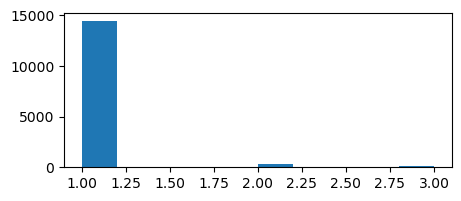

In [25]:
fig, ax = plt.subplots(figsize = (5, 2))
plt.hist(dataset['event_count'])

### Преобразуем данные

Наш набор данных содержит в себе 3 возможных события. 
</br>Благодаря предобработки мы установили конечное событие для каждого пользователя (user) и товара (item) с которым пользователь взаимодействовал. 
</br>Таким образом мы получили рейтинг пользователя (u) для товара (i):
- 0 - не было взаимодействия вообще
- 1 - товар был просмотрен, но не добавлен в корзину и не приобретен
- 2 - товар был добавлен в корзину, но не приобретен
- 3 - товар был приобретен
</br>
</br>Для наших данных (explicit data) мы будем использовать модель ALS - итеративный алгоритм рахложения матрицы.

In [26]:
# Add score: view = 1 else = 2
dataset['score'] = dataset['event_count'].apply(lambda x : 0 if x == 1.0 else (1 if x == 2.0 else 2))

In [27]:
# Remove columns
dataset.drop(columns = ['event', 'event_count', 'timestamp'], inplace = True)

Матрица получится большой размерности, что в дальнейшем приведет к проблемам с обработкой. 
</br>Для уменьшения размерности были использованы 3 метода. Наилучший результат показал последний метод.

## Методы сокращения кол-ва данных

### 1. Рандомные товары

In [28]:
# np.random.seed(10)

# multiplier = 1
# choose_num = 500
# item_0 = np.random.choice(dataset['itemid'][dataset['score'] == 0], choose_num, replace = False)
# item_1 = np.random.choice(dataset['itemid'][dataset['score'] == 1], choose_num, replace = False)
# item_2 = np.random.choice(dataset['itemid'][dataset['score'] == 2], choose_num, replace = False)

# items = list(item_0) + list(item_1) + list(item_2)
# items = set(items)

# dataset = dataset[dataset['itemid'].isin(items)]

# # remove_n = len(dataset[dataset['score'] == 0]) - (len(dataset[dataset['score'] == 1]) * multiplier)
# # score_zero = dataset[dataset['score'] == 0]

# # drop_indices = np.random.choice(score_zero.index, remove_n, replace=False)
# # df_zero = score_zero.drop(drop_indices)
# # df_one = dataset[dataset['score'] == 1]

# # dataset = df_one.append(df_zero).reset_index(drop = True)
# # dataset = dataset.sample(frac = 1).reset_index(drop = True)

# # Визуализация данных
# fig, ax = plt.subplots(figsize = (5, 2))
# plt.hist(dataset['score'])
# #plt.hist(dataset[dataset['itemid'].isin(items)]['score'])

### 2. Пользователи, которые взайимодействовали с товаром

In [29]:
# # Группировка по товару, считаем кол-во пользователей
# df_item = pd.DataFrame(dataset.groupby(['itemid'])['visitorid'].count()
#                       ).rename(columns = {'visitorid':'visitorid_count'}
#                               ).reset_index()

# # Отбор itemid, которые имеют кол-во пользователей равным или больше
# item_list = list(df_item[df_item['visitorid_count'] >= 1000]['itemid'])

# # Оставляем данные, которые имеют взаимодействие с товарами из списка
# #dataset = dataset[dataset['itemid'].isin(item_list)]
# dataset = dataset[(dataset['itemid'].isin(item_list)) | (dataset['score'] == 2)]

# # Визуализация
# fig, ax = plt.subplots(figsize = (5, 2))
# plt.hist(dataset['score'])

### 3. Пользователи, которые посмотрели товар

In [30]:
# # Отбор пользователей, которые посмотрели товар
# df_item = pd.DataFrame(dataset[dataset['score'] == 0].groupby(['itemid']
#                                                                )['visitorid'].count()
#                       ).rename(columns = {'visitorid':'visitor_count'}).reset_index()

# # Ограничение по кол-ву просмотров 
# item_list = list(df_item[df_item['visitor_count'] > 1000]['itemid'])

# # Оставляем только тех пользоватаелей, которые взаимодействовали с товаром из списка 
# # ИЛИ добавляли/приобретали какой-либо товар
# #dataset = dataset[(dataset['itemid'].isin(item_list)) | (dataset['score'] != 0)]
# dataset = dataset[dataset['itemid'].isin(item_list)]

# # Визуализация данных
# fig, ax = plt.subplots(figsize = (5, 2))
# plt.hist(dataset['score'])

### Валидация данных и преобразование выборок в матрицы

In [31]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size = 0.2, shuffle = False)

In [32]:
train_pivot = pd.pivot_table(train, index = 'visitorid', columns = 'itemid', values = 'score')
test_pivot = pd.pivot_table(test, index = 'visitorid', columns = 'itemid', values = 'score')

print(train_pivot.shape)
print(test_pivot.shape)

(8194, 10188)
(2120, 2814)


In [33]:
shell = pd.pivot_table(dataset, index = 'visitorid', columns = 'itemid', values = 'score', aggfunc = lambda x: 0)

In [34]:
train_pivot = shell + train_pivot
test_pivot = shell + test_pivot

train_pivot = (train_pivot + 1).fillna(0)
test_pivot = (test_pivot + 1).fillna(0)

print(train_pivot.shape)
print(test_pivot.shape)

train_pivot.head()

(10000, 12403)
(10000, 12403)


itemid,199,391,403,449,460,506,534,546,556,764,...,466513,466539,466614,466657,466675,466735,466740,466772,466847,466863
visitorid,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
train_pivot_sparse = scipy.sparse.csr_matrix(train_pivot.values)
test_pivot_sparse = scipy.sparse.csr_matrix(test_pivot.values)

<a id='als_surprise_model'></a>
## Модель

### Без параметров

In [36]:
model = AlternatingLeastSquares(factors = 10,random_state = 42)
model.fit(train_pivot_sparse)

D:\Users\leoge\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [37]:
unique_items = np.array(train_pivot.columns)
user_id = 195
recommendations_ids, scores = model.recommend(user_id, train_pivot_sparse[user_id])
recommendations = unique_items[recommendations_ids]
print('Recommendations ids: {}'.format(recommendations_ids))
print('Recommendations user {}: {}'.format(user_id, recommendations))

Recommendations ids: [8746 2467 8566 9081 3372 4738 2433 3945 2227 4120]
Recommendations user 195: [325283  92888 318455 339330 126388 177170  91886 147796  85055 154580]


In [38]:
map_at3 = mean_average_precision_at_k(model, train_pivot_sparse, test_pivot_sparse, K = 3)
print('Mean Average Precision at 3: {:.3f}, Percentage: {:.0f}%'.format(map_at3, map_at3*100))

  0%|          | 0/2120 [00:00<?, ?it/s]

Mean Average Precision at 3: 0.000, Percentage: 0%


## MAP@K

In [39]:
map_at_k_score_dict['ALS'] = round(map_at3*100, 2)
map_at_k_score_dict

{'collaborative': 0.1, 'ALS': 0.0}

### С параметрами

#### ВНИМАНИЕ!!! Подбор параметров вручную, так что будет требовать мощностей.

In [52]:
# Temporary dictionary for each parameter and for the best parameters
temp_dict = {}
factor_dict = {}
reg_dict = {}
iteration_dict = {}

class define_tune():
    def __init__(self, factors, reg, iterations):
        self._factors = factors
        self._reg = reg
        self._iterations = iterations
        
    def als_factors(self):
        for factor in self._factors:
            model = AlternatingLeastSquares(factors = factor, 
                                            use_cg = True, 
                                            calculate_training_loss = True, 
                                            random_state = 42)
            model.fit(train_pivot_sparse, show_progress=False)
            factor_string = str(factor)
            factor_dict[factor_string] = round((mean_average_precision_at_k(model, 
                                                                          train_pivot_sparse, 
                                                                          test_pivot_sparse, 
                                                                          K = 3, 
                                                                          show_progress=False)) * 100, 2)
        temp_dict['factors'] = int(max(factor_dict, key=factor_dict.get))
        
    def als_reg(self):
        for reg_item in self._reg:
            model = AlternatingLeastSquares(regularization = reg_item, 
                                            use_cg = True, 
                                            calculate_training_loss = True, 
                                            random_state = 42)
            model.fit(train_pivot_sparse, show_progress=False)
            reg_string = str(reg_item)
            reg_dict[reg_string] = round((mean_average_precision_at_k(model, 
                                                                          train_pivot_sparse, 
                                                                          test_pivot_sparse, 
                                                                          K = 3, 
                                                                          show_progress=False)) * 100, 2)
        temp_dict['regularization'] = float(max(reg_dict, key=reg_dict.get))
        
    def als_iterations(self):
        for iteration in self._iterations:
            model = AlternatingLeastSquares(iterations = iteration, 
                                            use_cg = True, 
                                            calculate_training_loss = True, 
                                            random_state = 42)
            model.fit(train_pivot_sparse, show_progress=False)
            iteration_string = str(iteration)
            iteration_dict[iteration_string] = round((mean_average_precision_at_k(model, 
                                                                          train_pivot_sparse, 
                                                                          test_pivot_sparse, 
                                                                          K = 3, 
                                                                          show_progress=False)) * 100, 2)
        temp_dict['iterations'] = int(max(iteration_dict, key=iteration_dict.get))
        
factors = range(10, 110, 10)
reg = [0.00001, 0.0001, 0.001, 0.01]
iterations = range(10, 50, 10)

define_tune(factors, reg, iterations).als_factors()
define_tune(factors, reg, iterations).als_reg()
define_tune(factors, reg, iterations).als_iterations()

model = AlternatingLeastSquares(factors = temp_dict['factors'], 
                                regularization = temp_dict['regularization'], 
                                iterations = temp_dict['iterations'], 
                                use_cg = True, 
                                calculate_training_loss = True, 
                                random_state = 42)
model.fit(train_pivot_sparse)

unique_items = np.array(train_pivot.columns)
user_id = 195
recommendations_ids, scores = model.recommend(user_id, train_pivot_sparse[user_id])
recommendations = unique_items[recommendations_ids]
print('Recommendations user {}: {}'.format(user_id, recommendations))

map_at10 = mean_average_precision_at_k(model, train_pivot_sparse, test_pivot_sparse, K = 10)
print('Mean Average Precision at 10: {:.3f}, Percentage: {:.0f}%'.format(map_at10, map_at10*100))

  0%|          | 0/20 [00:00<?, ?it/s]

Recommendations user 195: [335975 370653   5411 298009 187946 151444 309778 461686 384302 441668]


  0%|          | 0/3459 [00:00<?, ?it/s]

Mean Average Precision at 10: 0.191, Percentage: 19%


## Рекомендации

In [53]:
check_recommendation(list(recommendations[:3]))

Данные о товаре 335975:

Из 234838 товаров, рекомендуемый товар занимает 11 место по числу просмотров. Кол-во просмотров: 1428
Товар не имеет событий addtocart.
Товар не имеет событий transaction.

Данные о товаре 370653:

Из 234838 товаров, рекомендуемый товар занимает 4 место по числу просмотров. Кол-во просмотров: 1854
Товар не имеет событий addtocart.
Товар не имеет событий transaction.

Данные о товаре 5411:

Из 234838 товаров, рекомендуемый товар занимает 3 место по числу просмотров. Кол-во просмотров: 2325
Из 23903 товаров, рекомендуемый товар занимает 1214 место по добавлению в корзину. Кол-во добавлений в корзину: 9
Товар не имеет событий transaction.



## Подведем итоги:
<ul>
    <li>ALS требует большой нагрузки при большом кол-ве данных. Мы ограничены физически и должны сокращать кол-во данных, что влияет на персонализируемые рекомендации.</li>
    <li>Как мы видим, позиция и кол-во событий влияет на рекомендацию, но является неплохим решение для проблемы холодного старта - рекоммендовать новым пользователям более популярные товары.</li>
</ul>

[В начало](#begin)

<a id='factorization'></a>
# Матричная факторизация и факторизационные машины - LightFM

LightFM - реализация ряда популярных алгоритмов рекомендаций как для implicit data (неявных данных), так и для explicit data (явных данных).
</br>
</br>
Бдуем использовать тренировочную выборку из предыдущей задачи.

In [40]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

D:\Users\leoge\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Модель

In [41]:
model = LightFM(no_components = 10, loss = 'logistic', random_state = 42)
model.fit(train_pivot_sparse, epochs = 30)

## Рекомендации

In [42]:
item_ids = np.arange(0, train_pivot_sparse.shape[1])
list_pred = model.predict(user_id, item_ids)
recommendations_ids = np.argsort(-list_pred)[:10]
recommendations = unique_items[recommendations_ids]
print('Recommendations for user {}:{}'.format(user_id, recommendations))

Recommendations for user 195:[187946 370653 190000 102306 384302 461686 298009 309778  91755  65273]


In [45]:
check_recommendation(list(recommendations[:3]))

Данные о товаре 187946:

Из 12337 товаров, рекомендуемый товар занимает 10 место по числу просмотров. Кол-во просмотров: 20
Товар не имеет событий addtocart.
Товар не имеет событий transaction.

Данные о товаре 370653:

Из 12337 товаров, рекомендуемый товар занимает 18 место по числу просмотров. Кол-во просмотров: 15
Товар не имеет событий addtocart.
Товар не имеет событий transaction.

Данные о товаре 190000:

Из 12337 товаров, рекомендуемый товар занимает 15 место по числу просмотров. Кол-во просмотров: 18
Товар не имеет событий addtocart.
Товар не имеет событий transaction.



In [46]:
map_at3 = precision_at_k(model, test_pivot_sparse, k = 3).mean()
print('Mean Average Precision at 3: {:.3f}, Percentage: {:.0f}%'.format(map_at3, map_at3*100))

Mean Average Precision at 3: 0.000, Percentage: 0%


In [50]:
map_at_k_score_dict['LightFM'] = round(map_at3*100, 2)
map_at_k_score_dict

{'collaborative': 0.1, 'ALS': 0.0, 'LightFM': 0.02}

## Подведем итоги:
<ul>
    <li>Плохой результат, но правильная настройка модели поможет рекомендательной системы.</li>
    <li>Видим сходство с предыдущей моделью - рекоммендация более популярных товаров.</li>
</ul>

[В начало](#begin)

<a id='als_implicit'></a>
# Implicit ALS (Alternating Least Squares) - модель

Implicit ALS - хорошо работает с неявными данными.
</br>
Как мы помним, данные для рекомендательных систем делятся на две категории: 
<ul>
<li>Explicit (явные) - данные, которые отражают отношение пользователя к товару. Например, это может быть рейтинг фильму, оставленный пользователем.</li>
<li>Implicit (неявные) - данные, которые отражают поведение пользователя по отношению к товару. Например, количество просмотров или добавлений товара в корзину.</li>
</ul>
</br>
Преимущества: Мы вводим минимальный порог уровня доверия ($C$) по отношению к значению ($r_{ui}$).

$$\min_{x_{*}, y_{*}} \sum_{u,i} c_{ui}(p_{ui} - x_u^{T}y_i)^2 + \lambda(\sum_{u} ||\text{x}_{u}||^2 + \sum_{i} ||\text{y}_{i}||^2)$$

Разберем алгоритм:
</br>
</br>
- Бинарная оценка $p_{ui}$, которая, в зависимости от значения $r_{ui}$, принимает значение 1 или 0. Можно эксперемнтировать с подбором параметра. 
$$p_{ui}\in(0,1)$$
</br>
$$
p_{ui}=
\begin{cases}
1 & \text{если $r_{ui} > 0$}\\ 
0 & \text{если $r_{ui} = 0$}
\end{cases}
$$
</br>
- Оценка $r_{ui}$ из матрицы $R$. 
$$r_{ui}\in \mathbb{R}, \quad r_{ui}=x_u^T y_i$$
</br>
- Уровень доверия
$$C_{ui} = 1 + \alpha r_{ui}$$
</br>

- Оценка $r_{ui} = x_{u}^T y_{i}$. Как и ранее, чтобы вычислить глобальный минимум, мы фиксируем один из наборов со скрытыми факторами $x_{u}$ или $y_{i}$, считаем ф-ию потерь, и поочередно повторяем процедуру, но сейчас мы вводим минимальный порог, в виде уровня доверия $C$, необходимый для преодоления ф-ии потерь. Упростим выражение: 

$$x_u = (Y^T С^u Y + \lambda I)^{-1} Y^T С^u p(u) \implies (Y^T Y+ Y^T (С^{u} - I) Y + \lambda I)^{-1} Y^T С^u p(u)$$
$$y_i = (X^T С^i X + \lambda I)^{-1} X^T С^i p(i) \implies (X^T X+ X^T (С^{i} - I) X + \lambda I)^{-1} X^T С^i p(i)$$
</br>$\quad$- $X$ и $Y$ - разреженные матрицы users и items
</br>$\quad$- $С^u$ и $С^i$ - уровень доверия
</br>$\quad$- $\lambda$ - регуляризатор
</br>$\quad$- $p(u)$ и $p(i)$ - бинарное значение целевой переменной
</br>$\quad$- $I$ - единичная матрица
</br>
</br>
Схожесть между товарыми мы можем получить, рассчитав точечное произведение между всеми векторами items и транспонированным вектором товара.
$$\text{Оценка} = Y \cdot Y_{i}^T$$
</br>
Для нашего случае (рекомедации товаров) нам необходимо рассчитать точечное произведением между всеми векторами users и транспонированным вектором товара.
$$\text{Оценка} = X_i \cdot Y^T$$

## Датасет

In [51]:
df_temp = pd.read_csv('df_temp.csv', sep = ';').drop(columns = ['Unnamed: 0'])

df_temp = df_temp[df_temp['visitorid'] < 500000]

<a id='als_implicit_preprocessing'></a>
## Предобработка данных

Проведенные эксперименты показали лучший результат с ипользованием df_events, вместо df_temp, при одинаковом кол-ве записей.

In [52]:
dataset = df_temp.copy()
# df_events['event_count'] = df_events['event'].apply(lambda x: 1.0 if str(x) == 'view' else (2.0 if str(x) == 'addtocart' else 3.0))
# dataset = df_events[list(df_temp.columns)].copy()

(array([740030.,      0.,      0.,      0.,      0.,  15418.,      0.,
             0.,      0.,   7450.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

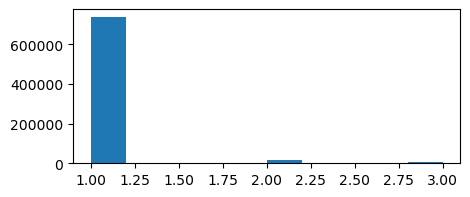

In [53]:
fig, ax = plt.subplots(figsize = (5, 2))
plt.hist(dataset['event_count'])

### Преобразуем данные

Наш набор данных содержит в себе 3 возможных события. 
</br>Благодаря предобработки мы установили конечное событие для каждого пользователя (user) и товара (item) с которым пользователь взаимодействовал. 
</br>Таким образом мы получили рейтинг пользователя (u) для товара (i):
- 0 - не было взаимодействия вообще
- 1 - товар был просмотрен, но не добавлен в корзину и не приобретен
- 2 - товар был добавлен в корзину, но не приобретен
- 3 - товар был приобретен
</br>
</br>Для наших данных (explicit data) мы будем использовать модель ALS - итеративный алгоритм рахложения матрицы.

In [54]:
# Add score: view = 1 else = 2
dataset['score'] = dataset['event_count'].apply(lambda x : 0 if x == 1.0 else (1 if x == 2.0 else 2))

# Remove columns
dataset.drop(columns = ['event', 'event_count', 'timestamp'], inplace = True)

Матрица получится большой размерности, что в дальнейшем приведет к проблемам с обработкой. 
</br>Для уменьшения размерности были использованы 3 метода. Наилучший результат показал последний метод.

### Пользователи, которые посмотрели товар

(array([503698.,      0.,      0.,      0.,      0.,  11560.,      0.,
             0.,      0.,   5771.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

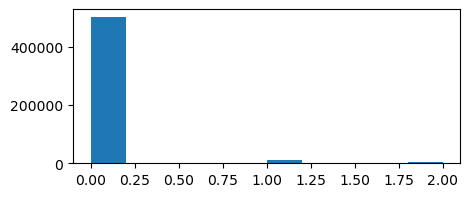

In [55]:
# Отбор пользователей, которые посмотрели товар
df_item = pd.DataFrame(dataset[dataset['score'] == 0].groupby(['itemid']
                                                               )['visitorid'].count()
                      ).rename(columns = {'visitorid':'visitor_count'}).reset_index()

# Ограничение по кол-ву просмотров 
item_list = list(df_item[df_item['visitor_count'] > 5]['itemid'])

# Оставляем только тех пользоватаелей, которые взаимодействовали с товаром из списка 
# ИЛИ добавляли/приобретали какой-либо товар
#dataset = dataset[(dataset['itemid'].isin(item_list)) | (dataset['score'] != 0)]
dataset = dataset[dataset['itemid'].isin(item_list)]

# Визуализация данных
fig, ax = plt.subplots(figsize = (5, 2))
plt.hist(dataset['score'])

## Использование PySpark

Подготовка среды, если не создан путь в системе.

In [56]:
# import os
# import sys
# spark_path = r"C:\spark"
# os.environ['SPARK_HOME'] = spark_path
# sys.path.insert(0, spark_path + "/bin")
# sys.path.insert(0, spark_path + "/python/pyspark/")
# sys.path.insert(0, spark_path + "/python/lib/pyspark.zip")
# sys.path.insert(0, spark_path + "/python/lib/py4j-0.10.3-src.zip")

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
# dataset = dataset.sort_values(['visitorid', 'itemid']).reset_index(drop = True)
# train, test = train_test_split(dataset, test_size = 0.2, shuffle = False)

train, test = train_test_split(dataset, test_size = 0.2, shuffle = True)

Импорт библиотек и модулей

In [59]:
from pyspark.sql import SparkSession # Create Session
from pyspark.sql import functions # Import functions
from pyspark.ml.recommendation import ALS # ALS model

from pyspark.ml.evaluation import RegressionEvaluator # RMSE

from pyspark import SparkContext, SparkConf

Создание сессии (SparkSession)

In [60]:
spark = SparkSession.builder \
        .appName('alsRecommendationApp') \
        .master('local') \
        .config('spark.sql.execution.arrow.pyspark.enabled', True) \
        .config('spark.sql.session.timeZone', 'UTC') \
        .config('spark.driver.memory','32G') \
        .config('spark.ui.showConsoleProgress', True) \
        .config('spark.sql.repl.eagerEval.enabled', True) \
        .getOrCreate()

conf = SparkConf().setAppName("appRecommendation").setMaster("local")
sc = SparkContext.getOrCreate(conf)

Предобработка PySpark DataFrame

In [61]:
def pandas_to_spark(df):
    # Pandas DataFrame to PySpark DataFrame
    df = spark.createDataFrame(df)

    # Rename columns
    df = df.withColumnRenamed('visitorid', 'userId'
                             ).withColumnRenamed('itemid', 'itemId'
                                                ).withColumnRenamed('score', 'rating')

    # Sort by userId & itemId columns
    df = df.sort("userId","itemId")
    return df

In [62]:
train = pandas_to_spark(train)
test = pandas_to_spark(test)

D:\Users\leoge\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:428: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


<a id='als_implicit_model'></a>
## Модель

### ALS Model

In [63]:
# Create ALS Model
als = ALS() \
    .setMaxIter(10) \
    .setRank(10) \
    .setAlpha(20) \
    .setRegParam(0.01) \
    .setUserCol("userId") \
    .setItemCol("itemId")

# Train ALS Model
model = als.fit(train)

# Transform test split - make predictions  
predictions = model.transform(test)
predictions = predictions.na.fill(0)



evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.2690730007631162

## RMSE

In [64]:
rmse_score_dict['ALS_Implicit'] = round(rmse, 2)

### Tune ALS Model

In [65]:
# ranks = [10, 20, 30, 40]
# regParams = [0.01, 0.1, 1]
# alpha = 40
# maxIter = 20
    
# def tune_ALS(train_data, validation_data, maxIter, ranks, regParams, alpha):
#     min_error = float('inf')
#     best_rank = -1
#     best_regularization = 0
#     best_model = None
    
#     for rank in ranks:
#         for reg in regParams:
#             # Create ALS model with parameters
#             als = ALS() \
#                     .setMaxIter(maxIter) \
#                     .setRank(rank) \
#                     .setRegParam(reg) \
#                     .setAlpha(alpha) \
#                     .setUserCol("userId") \
#                     .setItemCol("itemId")
            
#             # Train ALS model
#             model = als.fit(train)
            
#             # Transform test split - make predictions  
#             predictions = model.transform(test)
#             predictions = predictions.na.fill(0)
            
#             # Evaluate model - RMSE
#             evaluator = RegressionEvaluator(metricName="rmse",
#                                             labelCol="rating",
#                                             predictionCol="prediction")
#             rmse = evaluator.evaluate(predictions)
#             print('Latent factors = {} ; Regularization = {} ;'
#                   'RMSE = {:.2f}'.format(rank, reg, rmse))
            
#             # Choose best parameters
#             if rmse < min_error:
#                 min_error = rmse
#                 best_rank = rank
#                 best_regularization = reg
#                 best_model = model
#     print('\nBest model parameters: Latent factors = {} ;'
#           'Regularization = {} ; RMSE = {:.4f}'.format(best_rank, best_regularization, min_error))
#     return best_rank, best_regularization

# best_rank, best_reg = tune_ALS(train, test, maxIter, ranks, regParams, alpha)

### Best ALS Model

In [66]:
# # Create ALS model with parameters
# als = ALS() \
#         .setMaxIter(20) \
#         .setRank(best_rank) \
#         .setRegParam(best_reg) \
#         .setAlpha(40) \
#         .setUserCol("userId") \
#         .setItemCol("itemId")

# # Default ALS model with better params. To use in case of skipping the previous setting.
# # als = ALS() \
# #         .setMaxIter(20) \
# #         .setRank(40) \
# #         .setRegParam(0.1) \
# #         .setAlpha(40) \
# #         .setUserCol("userId") \
# #         .setItemCol("itemId")

# # Train ALS model
# model = als.fit(train)

# # Transform test split - make predictions  
# predictions = model.transform(test)
# predictions = predictions.na.fill(0)

# # Evaluate model - RMSE
# evaluator = RegressionEvaluator(metricName="rmse",
#                                 labelCol="rating",
#                                 predictionCol="prediction")
# rmse = evaluator.evaluate(predictions)
# print('RMSE = {:.2f}'.format(rmse))

## Рекомендации

### Тестируем предсказание

In [67]:
from tqdm.notebook import tqdm
try:
    # Choose random userId
    predictions_df = predictions.filter(predictions['prediction'] > 1.5).toPandas()#.groupby('userId').count()
    all_df = pd.DataFrame(columns = list(predictions_df.columns))
    prediction_count = pd.DataFrame(predictions_df.groupby(['userId'])['prediction'].count()).reset_index()
    random_users = np.random.choice(list(prediction_count['userId'][prediction_count['prediction'] >= 3]), 3)

    for userId in tqdm(random_users):
        choice = predictions_df[predictions_df['userId'] == userId].sort_values('prediction', ascending = False)[:3]
        all_df = all_df.append(choice)
    
    all_df['prediction'] = round(all_df['prediction'])
    all_df['user_choice'] = (all_df['rating'] - all_df['prediction']).apply(lambda x: 'Right' if x == 0 else 'Wrong')

    print('Из', len(all_df['user_choice']), 'рекомендаций, модель верно предсказала', len(all_df[all_df['user_choice'] == 'Right']))
except:
    print('Not enough training data. Try again. Less then 3 recommendations available.')

D:\Users\leoge\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


  0%|          | 0/3 [00:00<?, ?it/s]

Из 9 рекомендаций, модель верно предсказала 3


C:\Users\leoge\AppData\Local\Temp\ipykernel_16120\1979341589.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(choice)
C:\Users\leoge\AppData\Local\Temp\ipykernel_16120\1979341589.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(choice)
C:\Users\leoge\AppData\Local\Temp\ipykernel_16120\1979341589.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(choice)


## MAP@K

In [68]:
class mapak():
    def __init__(self, df, col, user_col, prediction_col, users_list):
        self.df = df
        self.col = col
        self.user_col = user_col
        self.prediction_col = prediction_col
        self.users_list = users_list
    
    # Mean Average Precision at K - score each individual
    def mapak_score(self, df, col):
        y_true = df[df[self.col] == 1]

        prediction_score = 0
        running_sum = 0

        for i, v in enumerate(df[self.col]):
            k = i+1
            if v == 1:
                prediction_score += 1
                running_sum += prediction_score/k
            else:
                prediction_score += 0
                running_sum += 0
        try:        
            return running_sum/len(y_true)
        except:
            return 0
    
    # Count the score for each user
    def mapak_count_score(self):
        temp_mapak_list = []

        for user in self.users_list:
            temp_df = self.df[self.df[self.user_col] == user].sort_values(self.prediction_col, ascending = False).head(3)
            temp_df['rating'] = temp_df['rating'].fillna(0).astype(int)
            temp_df['map'] = temp_df[self.prediction_col] - temp_df['rating'].astype(int)
            temp_df['map'] = temp_df['map'].apply(lambda x: 1 if x == 0 else 0)
            temp_mapak_list.append(self.mapak_score(temp_df, 'map'))

        return round(sum(temp_mapak_list) / len(self.users_list), 2)

In [72]:
map_at_k_score_dict['ALS_Implicit'] = mapak(all_df, 'map', 'userId', 'prediction', random_users).mapak_count_score()
map_at_k_score_dict

{'collaborative': 0.1, 'ALS': 0.0, 'LightFM': 0.02, 'ALS_Implicit': 0.33}

### Рекомендуем товары пользователю

In [76]:
# Create Spark DF from dataset
ratings = spark.createDataFrame(dataset)

# Rename columns
ratings = ratings.withColumnRenamed('visitorid', 'userId'
                                   ).withColumnRenamed('itemid', 'itemId'
                                                      ).withColumnRenamed('score', 'rating')

# Sort by userId & itemId columns
ratings = ratings.sort("userId","itemId")

D:\Users\leoge\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:428: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [77]:
# Create distinct userId DF
choosen_users = ratings.select(als.getUserCol()).distinct().toPandas()

# Take first distinct userId
# ratings.select(als.getUserCol()).distinct().limit(3)

# Create Spark DF for random users from predictions_df
users = spark.createDataFrame(np.random.choice(predictions_df[predictions_df['userId'].isin(list(choosen_users['userId'])
                                                                                           )]['userId'], 3)
                             ).withColumnRenamed('value', 'userId')

# Recommend 3 items for each userId
user_subset_recs = model.recommendForUserSubset(users, 3).toPandas()

# Export item & rating from list values in row
item_list = []
rating_list = []
for row in user_subset_recs['recommendations']:
    for line in row:
        splt = [item for item in line]
        item_list.append(splt[0])
        rating_list.append(splt[1])
        
# Create multiple userId
userId_list = []
for user in list(user_subset_recs['userId']):
    userId_list.extend([user, user, user])
    
# Create DF
userId_df = pd.DataFrame(userId_list, columns = ['userId'])
userId_df['items'] = item_list
userId_df['ratings'] = rating_list

D:\Users\leoge\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
D:\Users\leoge\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:428: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
D:\Users\leoge\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arro

In [78]:
check_recommendation(list(userId_df[:3]['items']))

Данные о товаре 194165:

Из 234838 товаров, рекомендуемый товар занимает 10898 место по числу просмотров. Кол-во просмотров: 48
Из 23903 товаров, рекомендуемый товар занимает 19327 место по добавлению в корзину. Кол-во добавлений в корзину: 1
Из 12025 товаров, рекомендуемый товар занимает 11940 место по покупкам. Кол-во покупок: 1

Данные о товаре 334786:

Из 234838 товаров, рекомендуемый товар занимает 42993 место по числу просмотров. Кол-во просмотров: 13
Из 23903 товаров, рекомендуемый товар занимает 22295 место по добавлению в корзину. Кол-во добавлений в корзину: 1
Из 12025 товаров, рекомендуемый товар занимает 6528 место по покупкам. Кол-во покупок: 1

Данные о товаре 370442:

Из 234838 товаров, рекомендуемый товар занимает 27798 место по числу просмотров. Кол-во просмотров: 21
Товар не имеет событий addtocart.
Из 12025 товаров, рекомендуемый товар занимает 2511 место по покупкам. Кол-во покупок: 2



## Подведем итоги:
<ul>
    <li>Хороший результат! Увеличен объем данных, что делает модель более персонализированной.</li>
    <li>RMSE уменьшилась.</li>
    <li>На рекомендуемые товары не влияет популярность товара.</li>
</ul>

[В начало](#begin)

# GradientBoost Classifier & XGBoost

XGBoost (Extreme Gradient Boost) - алгоритм, работающий с большими объемами данных и на высокой скорости. 
</br>
</br>
Преимущества использования XGBoost:
- Использование L1- и L2-регуляризации
- Сокращение - рассчитываем коэффициент усиления, если он меньше гамма, то сокращаем дерево, убирая лишние ветки/листья.
- Позволяет работать с разреженными матрицами не проседая в скорости обработки (метод похож на SGD стохастический градиентный спуск)
- Возможность паралелльного обучения, а используя cache-aware алгоритм он не перенагружает память процессора.

<a id='gradient'></a>
# GradientBoost Classifier

Начнем с регрессии и пройдемся сначала по GB (градиентный бустинг). Необходимо сделать предсказание непрерывной величины.
</br> 
</br> Задача градиентного бустинга для регрессии - минимизация ф-ии потерь $\text{L}(y_i, F(x))$. Можно взять любую, например, среднеквадратическую ошибку (MSE).
</br>
</br>
$$F_0(x) = \text{argmin}_{\gamma} \sum_{i=1}^{n} \text{L}(y_i, \hat{y})$$
</br>
</br> Инициализируем кол-во деревьев - $M$. Для $M$ деревьев будем считать ф-ию потерь (обычно кол-во = 100).
</br>
</br> Для каждого $i$ в дереве $m$ считаем производную ф-ии потерь:
</br>
$$r_{im} = - \left [\frac{\partial \text{L}(y_i, F(x_i))}{\partial F(x_i)}\right]_{F(x)=F_{m-1}(x)}$$
</br>
</br> Далее мы строим предсказание на основе нового дерева, зафиксировав полученные значения для дальнейшей оптимизации градиента и само дерево (terminal regions $R_{j,m}$, где: $m$ - индекс дерева, а $j$ - индекс каждого листа).
</br>
</br> Для каждого листа $j$ мы будем считать минимизировать ф-ию потерь, отталкиваясь от ошибки предыдущего предсказания.
</br>
</br>
$$\gamma_{jm} = \text{argmin}_{\gamma} \sum_{x_{i}\in{R_{ij}}} \text{L}(y_i, F_{m-1}(x_i) + \gamma)$$
</br>
</br>На этом этапе мы можем подставить выбранную ф-ию потерь, например, среднеквадратическую ошибку (MSE). 
</br>
</br>Т.к. это наше первое предсказание/первое дерево, то мы используем $F_0(x)$, значение которое мы вычислили ранее. Сейчас, с предсказанием на руках, мы можем использовать предыдущее предсказание и подставив все необходимые параметры:
</br>
$$F_m(x) = F_{m-1}(x) + \nu \sum_{j=1}^{J_{m}} \gamma_{jm}I(x \in R_{jm})$$

## GradientBoost Classification

Градиентный бустинг для решение задач классификации.
</br> 
</br> Для решения задач классификации градиентный бустинг предсказывает log-правдоподобие (log(likelihood)) и с помощью логит ф-ии возвращает вероятность (p) принадлежности к классу. 
</br>
</br>Для классификации будем использовать одну из самых распространненных ф-ий потерь - Log Loss (a.k.a Logistic Loss, Bernoulli Loss), которую модель будет оптимизировать. 
</br>Как и ранее мы делаем наше первое предсказание/первое дерево - $F_0(x)$.
</br>Поскольку увеличение правдоподобия влечет за собой более точное предсказывание, а модель лучше усваивает меньшие значения, то необходимо будет умножить ф-ию на -1. Так же преобразуем ф-ию:
</br>
</br>
$$\text{Log Loss} = \sum_{i=1}^{N} -y_{i}\log(p_{i})-(1-y_{i})\log(1-p_{i}) \implies \sum_{i=1}^{N} -y_i \log(\frac{p_i}{1-p_i})+\log(1+e^{\log(\frac{p_i}{1-p_i})})$$
</br>
</br>
Далее идет расчет производных 1-го порядка.
</br> Полученное значение является нашей вероятностью, которое мы можем перевести в правдоподобие.
</br>
</br>Следующие шаги повторяют алгоритм построения предсказания для регрессии. Не забываем про использование другой ф-ии.
</br>
</br>
$$r_{im} = - \left [\frac{\partial \text{L}(y_i, F(x_i))}{\partial F(x_i)}\right]_{F(x)=F_{m-1}(x)}$$
</br>
</br>Строим регрессионное дерево решение для $r_{im}$. Вычисляем $\gamma_{jm}$, так как оптимизация ф-ии потерь подразуемвает подбор неизвестного нам параметра, с помощью ф-ии потерь, которую мы используем для классификации.
</br>
</br>$$\gamma_{jm} = \text{argmin}_{\gamma} \sum_{x_{i}\in{R_{ij}}} \text{L}(y_i, F_{m-1}(x_i) + \gamma) \implies \text{argmin}_{\gamma} \sum_{x_{i}\in{R_{ij}}} -y_i [F_{m-1}(x_i) + \gamma] + \log(1 + e^{F_{m-1}(x_i + \gamma)})$$
</br>
</br>
</br>Чтобы вычислить $\gamma$ мы могли бы рассчитать произведеную 1-го порядка для $\gamma$, но дальнейший расчет был бы неприятен. Вместо этого мы применим аппроксимацию путем разложения в ряд Тейлора (Second Order Taylor Approximation).
</br> Пример расчета для одного листа с одним значением (нужда в сумме отпадает).
</br>
</br>
$$L(y_1, F_{m-1}(x_1) + \gamma) \approx L(y_1, F_{m-i}(x_1)) + \frac{\partial}{\partial F()}L(y_1, F_{m-1}(x_1)) \gamma + \frac{1}{2} \frac{\partial^{2}}{\partial F()^{2}} L(y_1, F_{m-1}(x_1)) \gamma^{2}$$
</br>
</br> Считаем произведную 1-го порядка для $\gamma$:
</br>
</br>$$\frac{\partial}{\partial \gamma} L(y_1, F_{m-1}(x_1) + \gamma) \approx \frac{\partial}{\partial F()}L(y_1, F_{m-1}(x_1)) + \frac{\partial^{2}}{\partial F()^{2}} L(y_1, F_{m-1}(x_1))\gamma = 0$$
</br>
$$\frac{\partial^{2}}{\partial F()^{2}} L(y_1, F_{m-1}(x_1))\gamma = - \frac{\partial}{\partial F()}L(y_1, F_{m-1}(x_1))$$
</br>
$$\gamma = \frac{- \frac{\partial}{\partial F()}L(y_1, F_{m-1}(x_1))}{\frac{\partial^{2}}{\partial F()^{2}} L(y_1, F_{m-1}(x_1))}$$
</br>
</br>Теперь мы можем подставить нашу ф-ию потерь и вычислить для нее производную.
</br>Вычислив оптимальное значение $\gamma$ для каждого листа мы готовы сделать новые предсказания:
</br>
</br>
$$F_m(x) = F_{m-1}(x) + \nu \sum_{j=1}^{J_{m}} \gamma_{jm}I(x \in R_{jm})$$

## Градиентный бустинг

Ранее мы не нуждались в признаках, т.к. использовали разреженные матрицы пользователей и товаров.
</br> Сейчас же основной акцент будет сделан на признаки.

<a id='upload'></a>
## Импорт библиотек

In [2]:
df_all_features = pd.read_csv('df_all_features.csv', sep = ';').drop(columns = ['Unnamed: 0'])

In [3]:
df_temp = pd.read_csv('df_temp.csv', sep = ';').drop(columns = ['Unnamed: 0'])

In [4]:
df_temp['transaction'] = df_temp['event'].apply(lambda x: 1 if x == 'transaction' else 0)

In [5]:
df_all_features = pd.merge(df_all_features, df_temp[['visitorid', 'itemid', 'transaction']], on = ['visitorid', 'itemid'], how = 'left')

In [6]:
df_all_features = df_all_features.sort_values('datetime', ascending = True)

In [7]:
df_all_features = df_all_features.drop(columns = ['event', 'timestamp', 'event_count', 
                                                  'datetime', 'date', 'day_of_week', 
                                                  'year', 'month', 'day', 'hour', 'minute'])

<a id='gradient_preprocessing'></a>
## Предобработка

In [8]:
from sklearn.model_selection import GridSearchCV # Param tune
from sklearn.model_selection import cross_val_score # Cross Validation
from xgboost import XGBClassifier # XGBoost  Classifier
from sklearn.ensemble import GradientBoostingClassifier # GradientBoost Classifier

from sklearn.preprocessing import StandardScaler # Standardize features
from sklearn.metrics import accuracy_score # Accuracy classification score

from sklearn.metrics import mean_squared_error # MSE

from sklearn.preprocessing import OneHotEncoder 


#import matplotlib as mpl
#import warnings
#warnings.filterwarnings('ignore')
#plt.style.use('ggplot')

In [9]:
# Create a copy
df_clear = df_all_features.copy()
df_clear = df_clear.fillna(0)

df_users_items = df_clear[['visitorid', 'itemid']]
df_clear.drop(columns = ['visitorid', 'itemid'], axis = 1, inplace = True)

#df_clear = df_clear.sample(frac = 0.1)

X = df_clear.drop(columns = ['transaction'], axis = 1)
y = df_clear['transaction']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Split DataFrame to train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False, random_state = 42)

# Standardize features
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

<a id='gradient_model'></a>
## Модель

Accuracy score: 0.991


<Axes: >

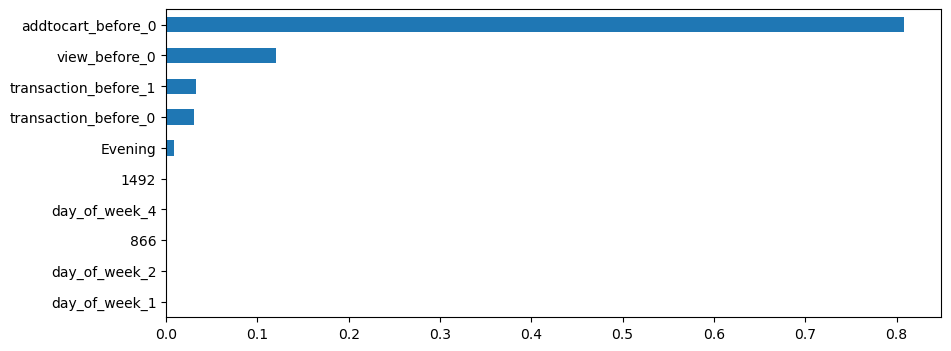

In [12]:
# Create model with params
clf = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 100, max_depth = 3, min_samples_split = 2,
                               min_samples_leaf = 1, subsample = 1, max_features = None)

# Fit train to model 
clf.fit(x_train, y_train)

# Predict test
y_pred = clf.predict(x_test)

# Accuracy score
print('Accuracy score:',round(accuracy_score(y_pred, y_test), 3))

# Show feature importances
pd.Series(clf.feature_importances_, index = X.columns).sort_values().tail(10).plot(kind = 'barh', figsize = (10,4))

Интересные показатели:
- addtocart_before_0 - Отсутствие добавления в коризину считается самым важным признаком, возможная причина - покупка одним кликом после просмотра.
- view_before_0 - Отсутствие просмотра. Возможные причины: ошибка при сохранении данных или прямая покупка без просмотра (не везде возможна из списка рекомендаций/каталога)
- transaction_before_1 - Логично, т.к. возможная покупка по графику.
- transaction_before_0 - Логично, т.к. первая покупка товара.
- Evening - При анализе большее кол-ве покупок приходилось на данное время суток.
- day_of_week_4 - При анализе большее кол-во покупок приходилось на данное время суток.

### Tune

In [360]:
# Parameters Grid
param_grid = {
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'n_estimators' : [100, 250],
    'max_depth': [3, 4, 5]
}

In [361]:
# Model
clf = GradientBoostingClassifier(max_depth = 3, 
                                 min_samples_split = 2,
                                 min_samples_leaf = 1, 
                                 subsample = 1, 
                                 max_features = None)

# Choose cross validation - 2 to speed up
cv_n = 2

clf_grid = GridSearchCV(clf, param_grid, scoring = 'accuracy', n_jobs = -1, cv = cv_n)

# Train with grid params
clf_grid.fit(x_train, y_train)

	ccp_alpha :0.0
	criterion :'friedman_mse'
	init :None
	learning_rate :0.0001
	loss :'log_loss'
	max_depth :3
	max_features :None
	max_leaf_nodes :None
	min_impurity_decrease :0.0
	min_samples_leaf :1
	min_samples_split :2
	min_weight_fraction_leaf :0.0
	n_estimators :100
	n_iter_no_change :None
	random_state :None
	subsample :1
	tol :0.0001
	validation_fraction :0.1
	verbose :0
	warm_start :False


In [364]:
# Choosing best params
best_parameters = clf_grid.best_estimator_.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s :%r' % (param_name, best_parameters[param_name]))

	ccp_alpha :0.0
	criterion :'friedman_mse'
	init :None
	learning_rate :0.0001
	loss :'log_loss'
	max_depth :3
	max_features :None
	max_leaf_nodes :None
	min_impurity_decrease :0.0
	min_samples_leaf :1
	min_samples_split :2
	min_weight_fraction_leaf :0.0
	n_estimators :100
	n_iter_no_change :None
	random_state :None
	subsample :1
	tol :0.0001
	validation_fraction :0.1
	verbose :0
	warm_start :False


In [363]:
# Predict test
y_pred = np.round(clf_grid.predict_proba(x_test)[:,1])

# Accuracy score
print('Accuracy score:',round(accuracy_score(y_pred, y_test), 3))

Accuracy score: 0.992


## Подведем итоги:
<ul>
    <li>Хороший результат Accuracy Score!.</li>
    <li>Использованы признаки датасета.</li>
</ul>

[В начало](#begin)

<b>Разобрались</b>, теперь мы продолжим с <b>XGBoost</b>.

<a id='xgboost'></a>
# XGBoost

XGBoost помогает решить задачу регрессии или классификации. 
</br>После разбора градиентного бустинга мы понимаем, что алгоритм оптимизации ф-ии потерь похож, но отличается методом подбора нужного параметра $\gamma$. 
</br>
</br>
$$\text{L}^{(t)} = \sum_{i=1}^{n} l(y_i, \hat{y}_{i}^{(t-1)} + f_{t}(x_i)) + \sum \gamma T + \frac{1}{2} \lambda ||w_j||^{2}$$
</br>
</br>$T$ - коэффициент сокращения
</br>$\frac{1}{2} \lambda ||w_i||^{2}$ - L2 регуляризация при расчете константы, L1 регуляризация при расчете предыдущей ошибки
</br>$\gamma T + \frac{1}{2} \lambda ||w_j||^{2}$ - можно встретить как равное $\Omega(f_j)$ ($j$ - индекс каждого листа)
</br>
</br>

<a id='upload'></a>
## Импорт библиотек

Будет использован датасет df_all_features_light, т.к. объем данных превыщает допустимый для использования на локальной машины.
- df_all_features_light - лайт версия df_all_features, в которой убраны признаки parentid.

In [36]:
df_all_features_light = pd.read_csv('df_all_features_light.csv', sep = ';').drop(columns = ['Unnamed: 0'])

df_all_features_light = df_all_features_light.sort_values('datetime', ascending = True)
df_all_features_light = df_all_features_light.drop(columns = ['event', 'timestamp', 'event_count', 
                                                  'datetime', 'date', 'day_of_week', 
                                                  'year', 'month', 'day', 
                                                  'hour', 'minute'])

### Импорт библиотек

In [38]:
from sklearn.model_selection import GridSearchCV # Param tune
from sklearn.model_selection import cross_val_score # Cross Validation
from xgboost import XGBClassifier # XGBoost  Classifier
from sklearn.ensemble import GradientBoostingClassifier # GradientBoost Classifier

from sklearn.preprocessing import StandardScaler # Standardize features
from sklearn.preprocessing import OneHotEncoder # OneHotEncoder
from sklearn.metrics import accuracy_score # Accuracy classification score

from sklearn.model_selection import train_test_split # Train & test split
from sklearn.metrics import mean_squared_error # MSE

import matplotlib.pyplot as pyplot # Plot graph

#import matplotlib as mpl
#import warnings
#warnings.filterwarnings('ignore')
#plt.style.use('ggplot')

## XGBoostClassifier

## 

<a id='xgboost_preprocessing'></a>
## Предобработка

In [39]:
# Create a copy
#df_clear = df_all_features_light.copy()
df_clear = df_all_features_light.copy()
df_clear = df_clear.reset_index(drop = True)
df_clear = df_clear.fillna(0)

#df_users_items = df_clear[['visitorid', 'itemid']]
#df_clear.drop(columns = ['visitorid', 'itemid'], axis = 1, inplace = True)

#df_clear = df_clear.sample(frac = 0.1)

X = df_clear.drop(columns = ['transaction'], axis = 1)
y = df_clear[['visitorid', 'itemid', 'transaction']]

In [40]:
# Split DataFrame to train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False, random_state = 42)

# Create groups
groups_x_train = np.array(x_train.groupby(['visitorid'])['itemid'].count())
groups_x_test = np.array(y_train.groupby(['visitorid'])['itemid'].count())

# Create original visitorid & itemid list
x_test_list = x_test[['visitorid', 'itemid']]

# Drop visitorid and itemid
# x_train.drop(columns = ['visitorid', 'itemid'], axis = 1, inplace = True)
# x_test.drop(columns = ['visitorid', 'itemid'], axis = 1, inplace = True)

In [41]:
for split in [x_train, x_test, y_train, y_test]:
    split.drop(columns = ['visitorid', 'itemid'], axis = 1, inplace = True)

In [42]:
# # Standardize features
# scaler = StandardScaler()

# x_train = scaler.fit_transform(x_train)
# x_test = scaler.fit_transform(x_test)

In [43]:
# x_train.columns=[str(col) for col in x_train.columns]
# x_test.columns=x_train.columns

# import xgboost as xgb

# dmat_train=xgb.DMatrix(x_train,y_train,feature_names=x_train.columns)
# dmat_val=xgb.DMatrix(x_test,y_test,feature_names=x_test.columns)

# model=xgb.train(params,
#                   dmat_train,
#                   evals=[(dmat_train,'train'),(dmat_val,'validation')])

# # transform probabilities to prediction labels (0,1)
# train_preds=[1 if pred>0.5 else 0 for pred in model.predict(data=dmat_train)]
# val_preds=[1 if pred>0.5 else 0 for pred in model.predict(data=dmat_val)]

<a id='xgboost_model'></a>
## Модель

In [44]:
eval_set = [(x_train, y_train), (x_test, y_test)]
#eval_metric = ['auc','error'] # Choose for AUC metrices
eval_metric=["error", "logloss"] # Choose for LogLoss metrices

In [50]:
# Model
xgb = XGBClassifier(objective = 'binary:logistic',
                    #nthread = 1,
                    gamma = 2,
                    n_estimators = 300,
                    learning_rate = 0.001,
                    n_jobs = -1, 
                    verbose = 2)

In [51]:
xgb.fit(x_train, 
        y_train, 
        eval_set=eval_set, 
        eval_metric=eval_metric, 
        verbose=True)

D:\Users\leoge\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[12:45:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-error:0.00924	validation_0-logloss:0.69217	validation_1-error:0.00913	validation_1-logloss:0.69217
[1]	validation_0-error:0.00924	validation_0-logloss:0.69120	validation_1-error:0.00913	validation_1-logloss:0.69120
[2]	validation_0-error:0.00924	validation_0-logloss:0.69023	validation_1-error:0.00913	validation_1-logloss:0.69023
[3]	validation_0-error:0.00924	validation_0-logloss:0.68926	validation_1-error:0.00913	validation_1-logloss:0.68926
[4]	validation_0-error:0.00924	validation_0-logloss:0.68830	validation_1-error:0.00913	validation_1-logloss:0.68830
[5]	

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [52]:
# Predict target
y_pred = xgb.predict(x_test)

### XGBoost features importances

Значения df_all_features_light

<Axes: >

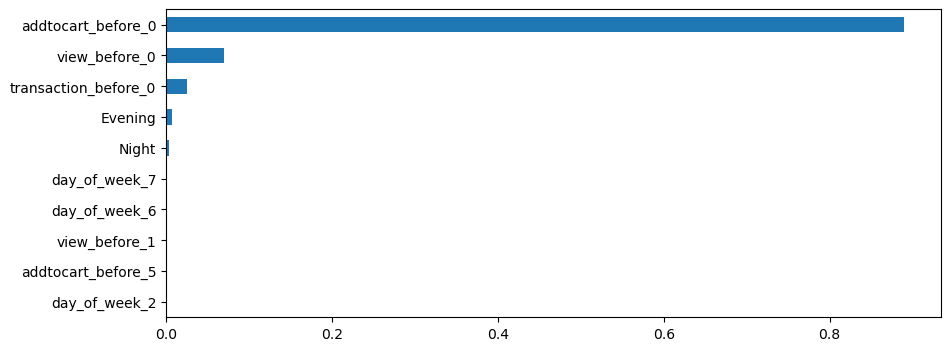

In [15]:
# Show feature importances
pd.Series(xgb.feature_importances_, index = X.drop(columns = ['visitorid', 'itemid']).columns).sort_values().tail(10).plot(kind = 'barh', figsize = (10,4))

### LogLoss Error

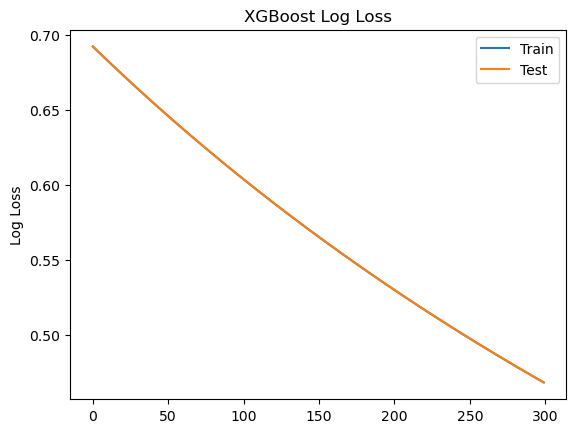

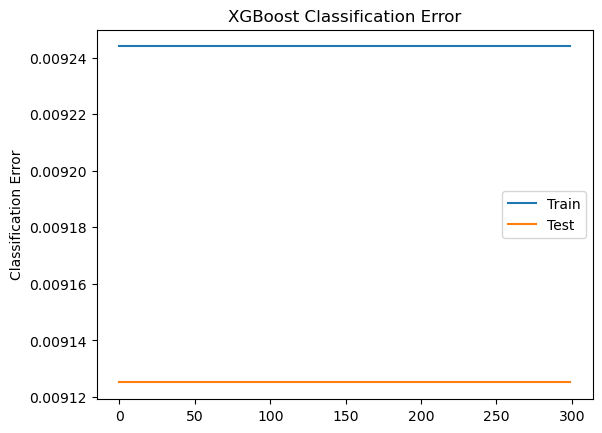

In [53]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

### AUC Error

In [186]:
# results = xgb.evals_result()
# epochs = len(results['validation_0']['error'])
# x_axis = range(0, epochs)

# fig, ax = pyplot.subplots()
# ax.plot(x_axis, results['validation_0']['auc'], label='Train')
# ax.plot(x_axis, results['validation_1']['auc'], label='Test')
# ax.legend()
# pyplot.ylabel('AUC')
# pyplot.title('XGBoost AUC')
# pyplot.show()

### Accuracy score

In [26]:
# Accuracy score
print('Accuracy score:',round(accuracy_score(y_pred, y_test), 3))

Accuracy score: 0.991


In [27]:
# Choose only items, that will be selled
predicted_items = pd.DataFrame(data={'itemid':x_test_list['itemid'], 'target':y_pred})

predicted_yes = predicted_items[predicted_items['target'] == 1.0]
predicted_no = predicted_items[predicted_items['target'] == 0.0]

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

D:\Users\leoge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\leoge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    424769
         1.0       1.00      0.04      0.07      4067
         2.0       0.81      1.00      0.90       161
         3.0       0.00      0.00      0.00        31
         4.0       0.00      0.00      0.00         2
         5.0       0.00      0.00      0.00         4
         9.0       0.00      0.00      0.00         1
        14.0       0.00      0.00      0.00         1

    accuracy                           0.99    429036
   macro avg       0.35      0.25      0.25    429036
weighted avg       0.99      0.99      0.99    429036



D:\Users\leoge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Tune

In [42]:
params = {
        #'min_child_weight' : [1, 5, 10],
        'gamma' : [0.5, 1, 1.5, 2],
        #'subsample' : [0.6, 0.8, 1.0],
        #'colsample_bytree' : [0.6, 0.8, 1.0],
        #'max_depth' : [3, 4, 5],
        #'n_estimators' : [100, 250, 500],
        #'learning_rate' : [0.0001, 0.001, 0.01, 0.1]
        }

In [43]:
# Model
xgb = XGBClassifier(objective = 'binary:logistic',
                    nthread = 1,
                    n_estimators = 100,
                    learning_rate = 0.0001,
                    n_jobs = -1)

# Choose cross validation - 2 to speed up
n_cv = 2

# skf = StratifiedKFold(n_splits = n_cv, 
#                       shuffle = False)

clf_grid = GridSearchCV(xgb,
                       params,
                       n_jobs = -1, 
                       cv = 2, #skf.split(x_train,y_train), 
                       scoring = 'accuracy',
                       verbose = 3)

# Train with grid params
clf_grid.fit(x_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.0001, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1, nthread=1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             n_jobs=-1, param_grid={'gamma': [0.5, 1, 1.5, 2]},
             scoring='accuracy', verbose=3)

In [69]:
print('\n All results:')
print(clf_grid.cv_results_)
print('\n Best estimator:')
print(clf_grid.best_estimator_)
print('\n Best hyperparameters:')
print(clf_grid.best_params_)
#results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([211.25832367, 212.90275705, 245.62185717, 148.38638461]), 'std_fit_time': array([1.58407807, 1.42924821, 6.1689322 , 2.41107357]), 'mean_score_time': array([4.70164216, 4.15274167, 2.98400879, 2.68381011]), 'std_score_time': array([0.49020946, 0.46463871, 0.01844978, 0.01350486]), 'param_gamma': masked_array(data=[0.5, 1, 1.5, 2],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.5}, {'gamma': 1}, {'gamma': 1.5}, {'gamma': 2}], 'split0_test_score': array([0.97948491, 0.97948491, 0.97948491, 0.97948491]), 'split1_test_score': array([0.97988374, 0.97988374, 0.97988374, 0.97988374]), 'mean_test_score': array([0.97968432, 0.97968432, 0.97968432, 0.97968432]), 'std_test_score': array([0.00019941, 0.00019941, 0.00019941, 0.00019941]), 'rank_test_score': array([1, 1, 1, 1])}

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_byle

In [75]:
y_pred = clf_grid.predict(x_test)

results_df = pd.DataFrame(data={'itemid':x_test_list['itemid'], 'target':y_pred})
results_df['target'] = np.round(results_df['target'])
results_yes = results_df[results_df['target'] == 1.0]

In [76]:
# Accuracy score
print('Accuracy score:',round(accuracy_score(y_pred, y_test), 3))

Accuracy score: 0.979


In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     89430
         1.0       0.94      0.07      0.13      2089

    accuracy                           0.98     91519
   macro avg       0.96      0.53      0.56     91519
weighted avg       0.98      0.98      0.97     91519



## Подведем итоги:
<ul>
    <li>Скорость обработки увеличилась.</li>
    <li>Увеличен допустимый объем данных.</li>
</ul>

[В начало](#begin)

# Заключение:
<ul>
    <li>Наилучшее решение, в данной задаче, использовать ALS модель, так как мы ограничены в признаках. </li>
</ul>
Ключевые признаки для приобретения товара:
<ul>
    <li>Время суток (вечер и/или ночь).</li>
    <li>Прямые клики по покупке товара. При условии, что это не отклонение из-за ограниченного потока данных.</li>
    <li>Покупки на выходные дни.</li>
</ul>

### Дальнейшие действия:
<br>
Как показала метрика MAP@K, наилучшим решением будет использовать ALS из библотеки PySpark. К тому же, благодаря Java мы не только увеличиваем скорость работы модели, но и увеличиваем объем используемых данных.

In [73]:
pd.DataFrame(pd.Series(map_at_k_score_dict))

{'collaborative': 0.1, 'ALS': 0.0, 'LightFM': 0.02, 'ALS_Implicit': 0.33}

In [74]:
pd.DataFrame(pd.Series(rmse_score_dict))

{'collaborative': 0.22, 'ALS_Implicit': 0.27}